# TIME SERIES ANALYSIS IN SPARK FOR NETFLIX STOCK PRICE PREDICTION

Install PySpark

In [ ]:
pip install pyspark


Import the necessary libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

Create a Spark session

In [ ]:
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

Loading dataset

In [ ]:
df = spark.read.csv("/content/NFLX.csv", header=True, inferSchema=True)

In [ ]:
df.show()

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|2002-05-23|1.156429|1.242857|1.145714|1.196429| 1.196429|104790000|
|2002-05-24|1.214286|   1.225|1.197143|    1.21|     1.21| 11104800|
|2002-05-28|1.213571|1.232143|1.157143|1.157143| 1.157143|  6609400|
|2002-05-29|1.164286|1.164286|1.085714|1.103571| 1.103571|  6757800|
|2002-05-30|1.107857|1.107857|1.071429|1.071429| 1.071429| 10154200|
|2002-05-31|1.078571|1.078571|1.071429|1.076429| 1.076429|  8464400|
|2002-06-03|    1.08|1.149286|1.076429|1.128571| 1.128571|  3151400|
|2002-06-04|1.135714|    1.14|1.110714|1.117857| 1.117857|  3105200|
|2002-06-05|1.110714|1.159286|1.107143|1.147143| 1.147143|  1531600|
|2002-06-06|    1.15|1.232143|1.148571|1.182143| 1.182143|  2305800|
|2002-06-07|1.177857|1.177857|1.103571|1.118571| 1.118571|  1369200|
|2002-06-10|   1.135|   1.175|1.13

In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- rolling_mean: double (nullable = true)
 |-- rolling_stddev: double (nullable = true)
 |-- sma: double (nullable = true)
 |-- ema: double (nullable = true)
 |-- upper_band: double (nullable = true)
 |-- lower_band: double (nullable = true)



Data Preprocessing

In [ ]:
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Convert the 'Date' column to a datetime object
df = df.withColumn("datetime", to_timestamp(col("Date")))

# Sort the data by datetime
df = df.orderBy("datetime")

# Drop any rows with missing values
df = df.dropna()

Time Series Analysis

In [ ]:
import pyspark.sql.functions as F

window_spec = Window.orderBy("datetime").rowsBetween(-3, 3)  # Adjust the window as needed
df = df.withColumn("rolling_mean", F.avg("Close").over(window_spec))
df = df.withColumn("rolling_stddev", F.stddev("Close").over(window_spec))

Data Visualization

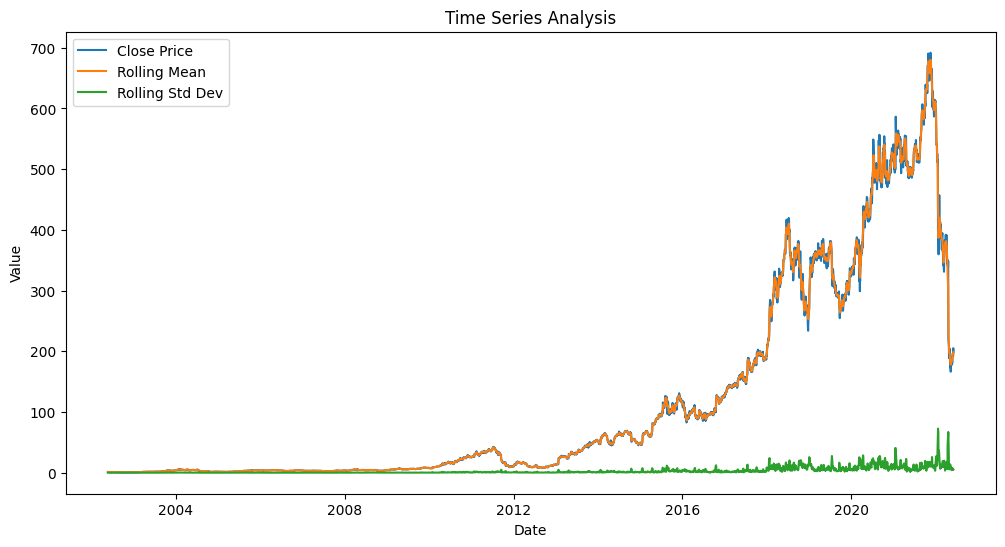

In [ ]:
# Extract the necessary columns for visualization
dates = df.select("datetime").rdd.flatMap(lambda x: x).collect()
prices = df.select("Close").rdd.flatMap(lambda x: x).collect()

# Create a time series line chart
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label="Close Price")
plt.plot(dates, df.select("rolling_mean").rdd.flatMap(lambda x: x).collect(), label="Rolling Mean")
plt.plot(dates, df.select("rolling_stddev").rdd.flatMap(lambda x: x).collect(), label="Rolling Std Dev")
plt.title("Time Series Analysis")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

INDICATORS

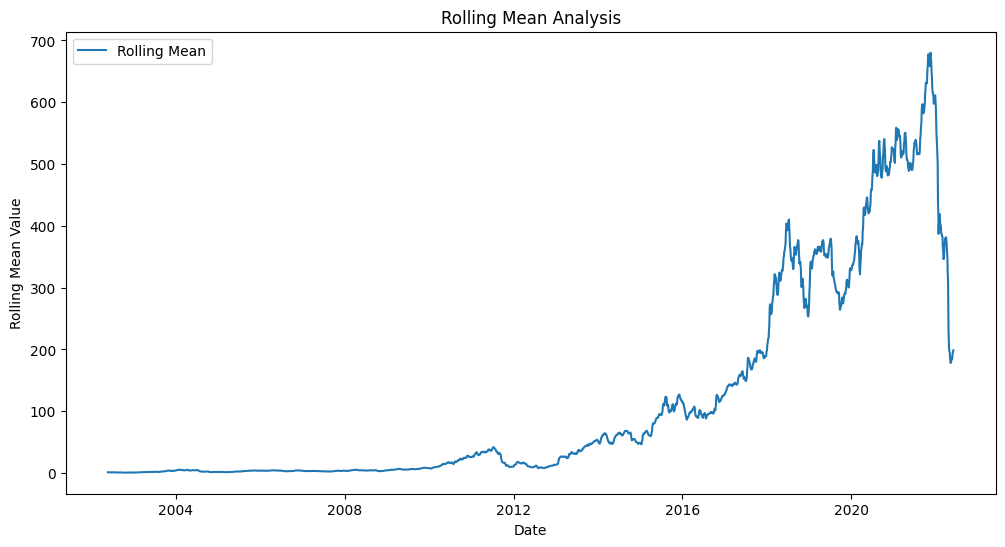

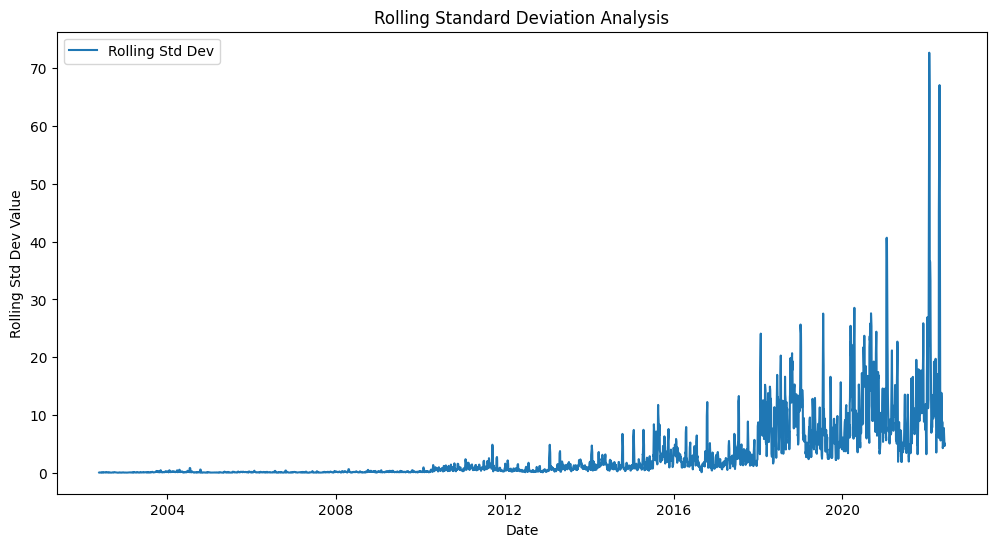

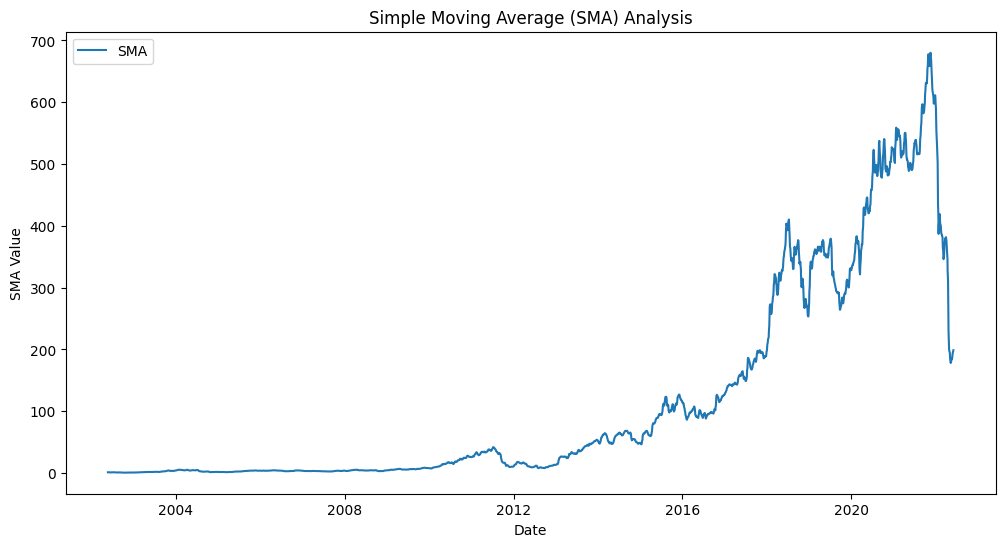

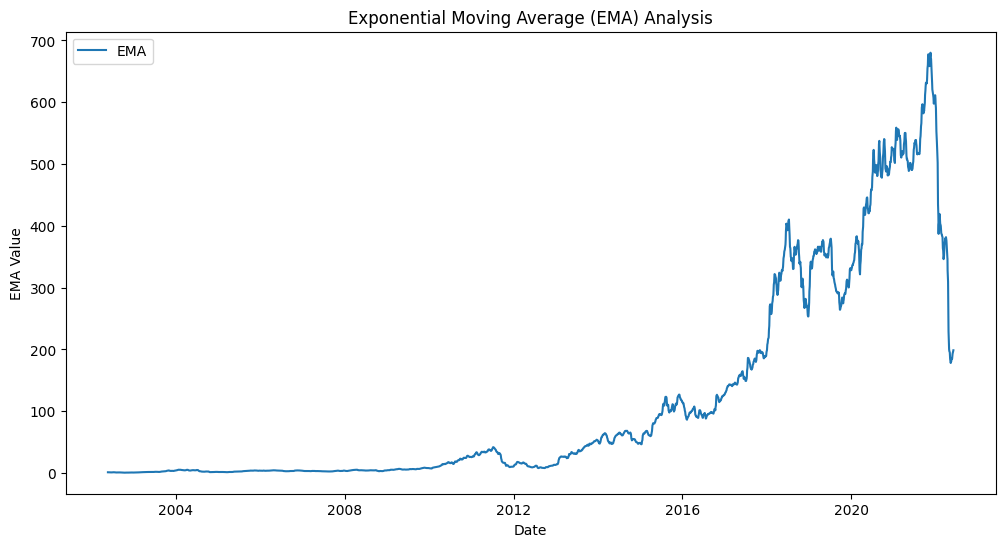

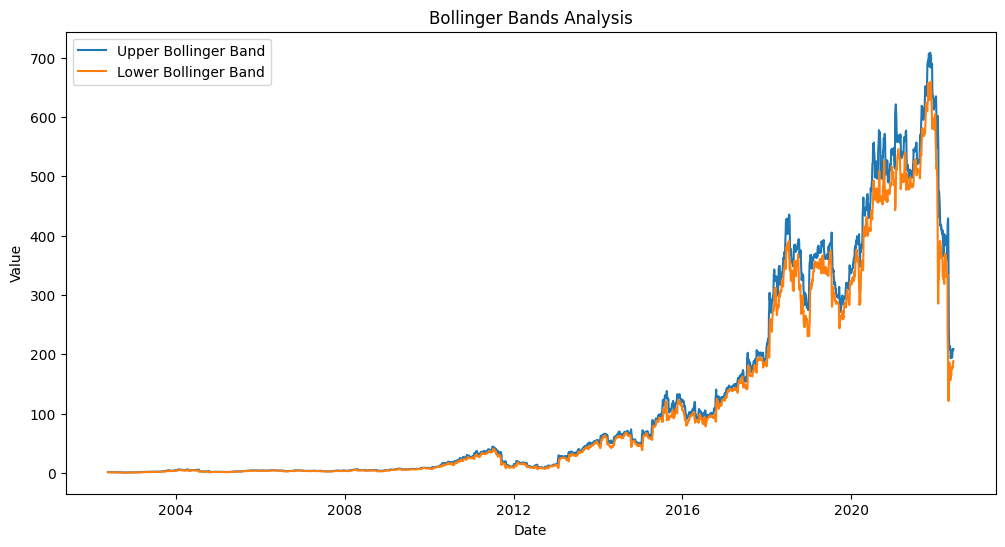

In [ ]:
import matplotlib.pyplot as plt

# Extract the necessary columns for visualization
dates = df.select("datetime").rdd.flatMap(lambda x: x).collect()
prices = df.select("Close").rdd.flatMap(lambda x: x).collect()

# Create individual time series line charts for each indicator
plt.figure(figsize=(12, 6))
plt.plot(dates, df.select("rolling_mean").rdd.flatMap(lambda x: x).collect(), label="Rolling Mean")
plt.title("Rolling Mean Analysis")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, df.select("rolling_stddev").rdd.flatMap(lambda x: x).collect(), label="Rolling Std Dev")
plt.title("Rolling Standard Deviation Analysis")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, df.select("sma").rdd.flatMap(lambda x: x).collect(), label="SMA")
plt.title("Simple Moving Average (SMA) Analysis")
plt.xlabel("Date")
plt.ylabel("SMA Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, df.select("ema").rdd.flatMap(lambda x: x).collect(), label="EMA")
plt.title("Exponential Moving Average (EMA) Analysis")
plt.xlabel("Date")
plt.ylabel("EMA Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, df.select("upper_band").rdd.flatMap(lambda x: x).collect(), label="Upper Bollinger Band")
plt.plot(dates, df.select("lower_band").rdd.flatMap(lambda x: x).collect(), label="Lower Bollinger Band")
plt.title("Bollinger Bands Analysis")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


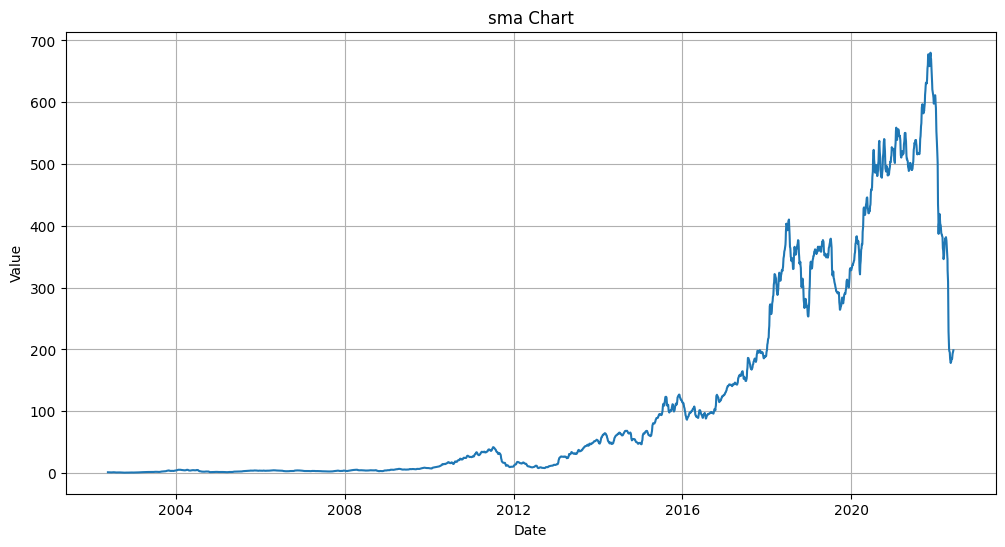

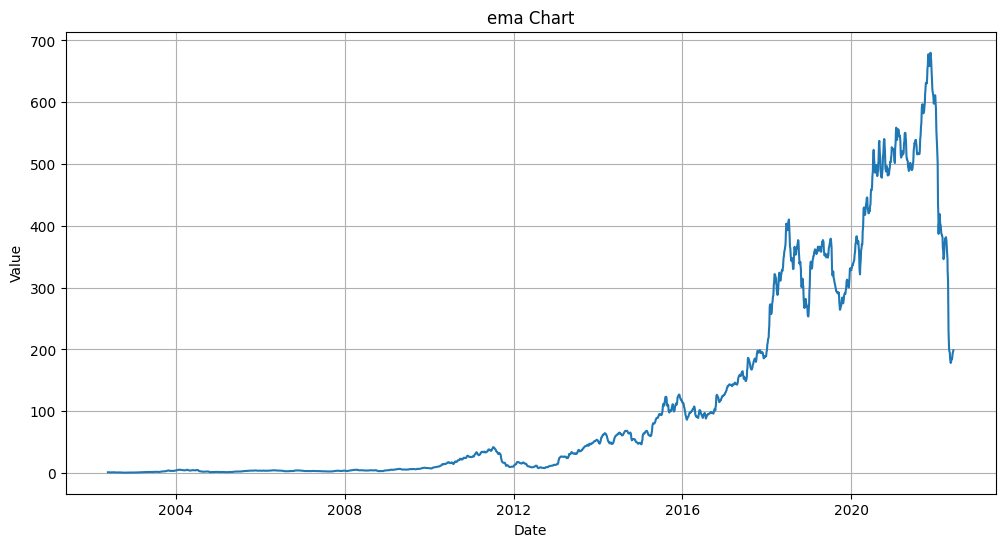

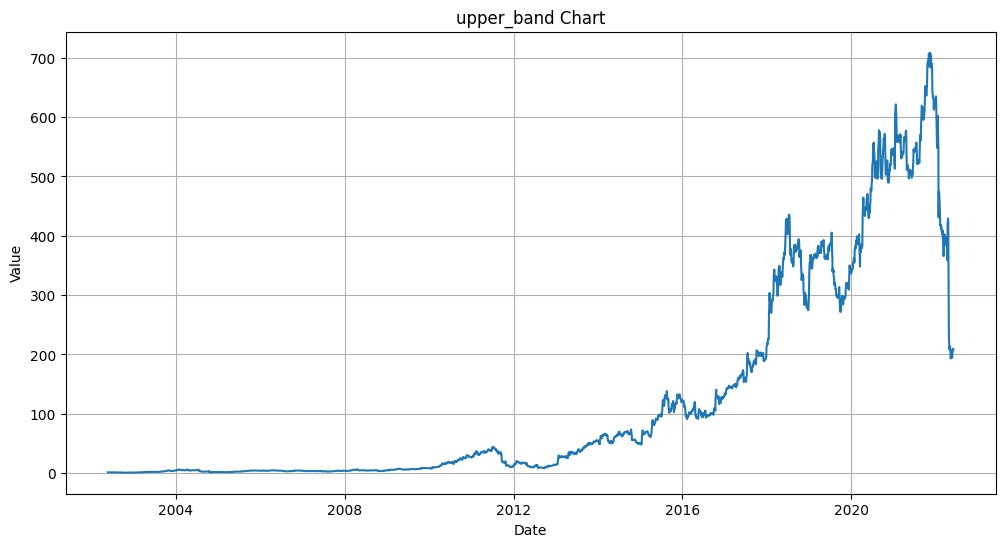

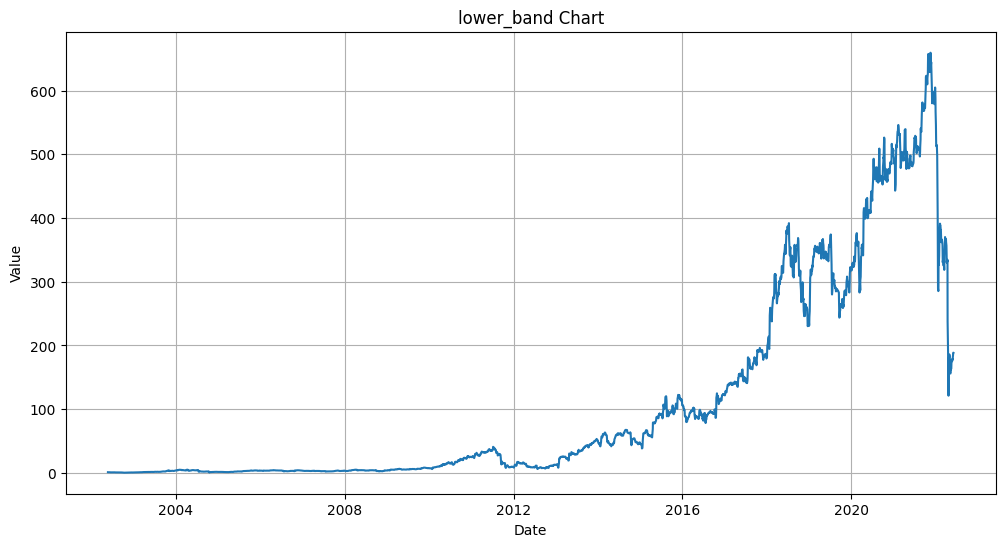

In [ ]:
# Calculate Simple Moving Average (SMA)
sma_window_spec = Window.orderBy("datetime").rowsBetween(-3, 3)
df = df.withColumn("sma", F.avg("Close").over(sma_window_spec))

# Calculate Exponential Moving Average (EMA)
ema_window_spec = Window.orderBy("datetime").rowsBetween(-3, 3)
df = df.withColumn("ema", F.avg("Close").over(ema_window_spec))

# Calculate Bollinger Bands
bollinger_window_spec = Window.orderBy("datetime").rowsBetween(-3, 3)
df = df.withColumn("rolling_stddev", F.stddev("Close").over(bollinger_window_spec))
df = df.withColumn("upper_band", F.col("sma") + 2 * F.col("rolling_stddev"))
df = df.withColumn("lower_band", F.col("sma") - 2 * F.col("rolling_stddev"))

# Create separate graphs for each indicator
indicator_names = ["sma", "ema", "upper_band", "lower_band"]

for indicator_name in indicator_names:
    plt.figure(figsize=(12, 6))
    plt.plot(df.select("datetime").collect(), df.select(indicator_name).collect())
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"{indicator_name} Chart")
    plt.grid(True)
    plt.show()

In [ ]:
pip install --upgrade statsmodels

ADF Statistic: -1.2470207311260355
p-value: 0.6530488146407217
Critical Values: {'1%': -3.4316556581508197, '5%': -2.862116959995152, '10%': -2.567077116457145}
ADF Statistic after differencing: -10.662460987641184
p-value after differencing: 4.371659316898826e-19
Critical Values after differencing: {'1%': -3.4316559188949403, '5%': -2.8621170751906178, '10%': -2.567077177780168}


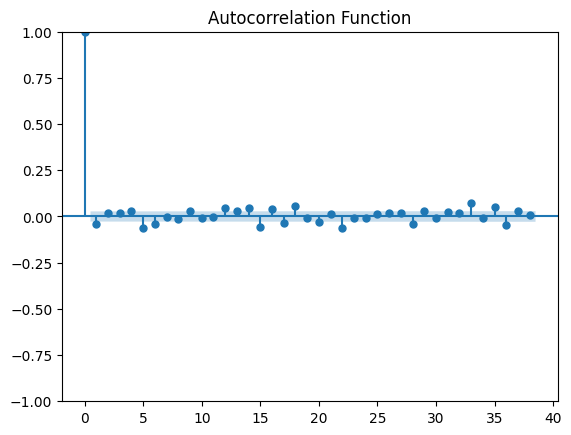

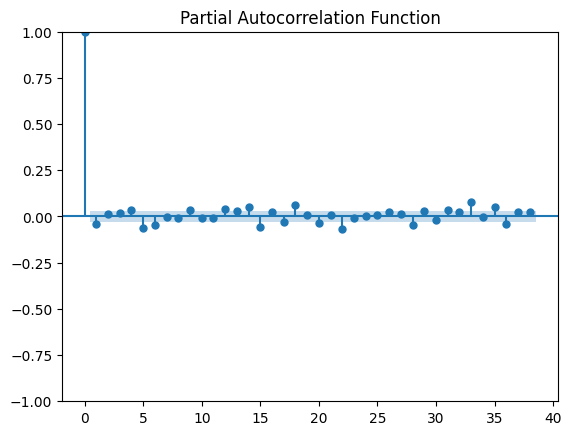

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

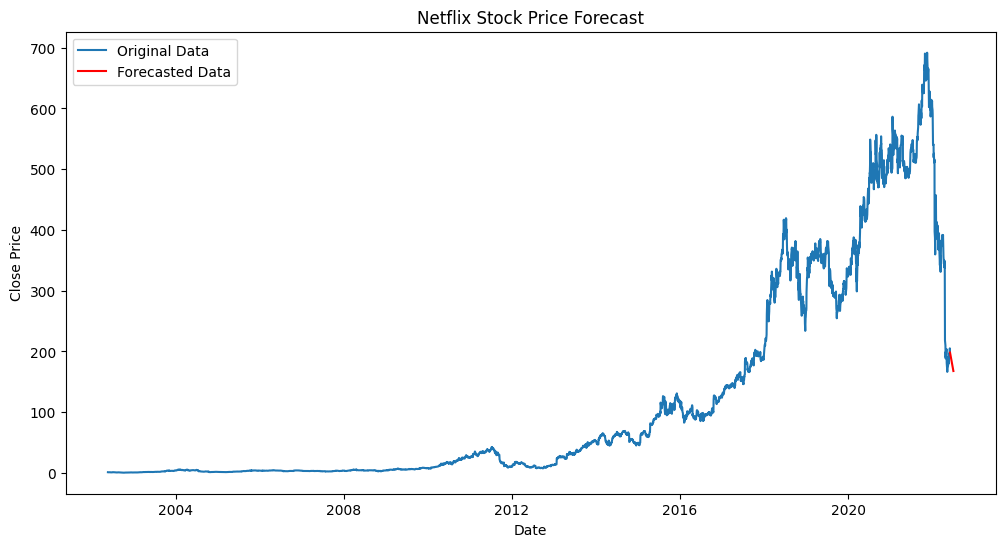

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset (replace 'NFLX.csv' with the actual file path)
data = pd.read_csv("NFLX.csv")

# Convert the 'Date' column to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Check stationarity using Augmented Dickey-Fuller test
result = adfuller(data['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# If the data is not stationary, apply differencing
if result[1] > 0.05:
    data_diff = data['Close'].diff().dropna()
    result_diff = adfuller(data_diff)
    print("ADF Statistic after differencing:", result_diff[0])
    print("p-value after differencing:", result_diff[1])
    print("Critical Values after differencing:", result_diff[4])
else:
    data_diff = data['Close']

# Plot ACF and PACF to determine ARIMA order (p, d, q)
plot_acf(data_diff)
plt.title("Autocorrelation Function")
plt.show()

plot_pacf(data_diff)
plt.title("Partial Autocorrelation Function")
plt.show()

# Fit ARIMA model
model = ARIMA(data_diff, order=(1, 1, 1))
model_fit = model.fit()

# Forecast future values
forecast_steps = 30  # Adjust the number of future steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecasted values
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, closed='right')

# Inverse difference to obtain the actual forecasted values
forecast_values = np.cumsum(forecast) + data['Close'].iloc[-1]

# Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Original Data")
plt.plot(forecast_index, forecast_values, label="Forecasted Data", color='red')
plt.title("Netflix Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()